[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerator
[13:35:31] DEPRECATION WARNING: please use MorganGenerat

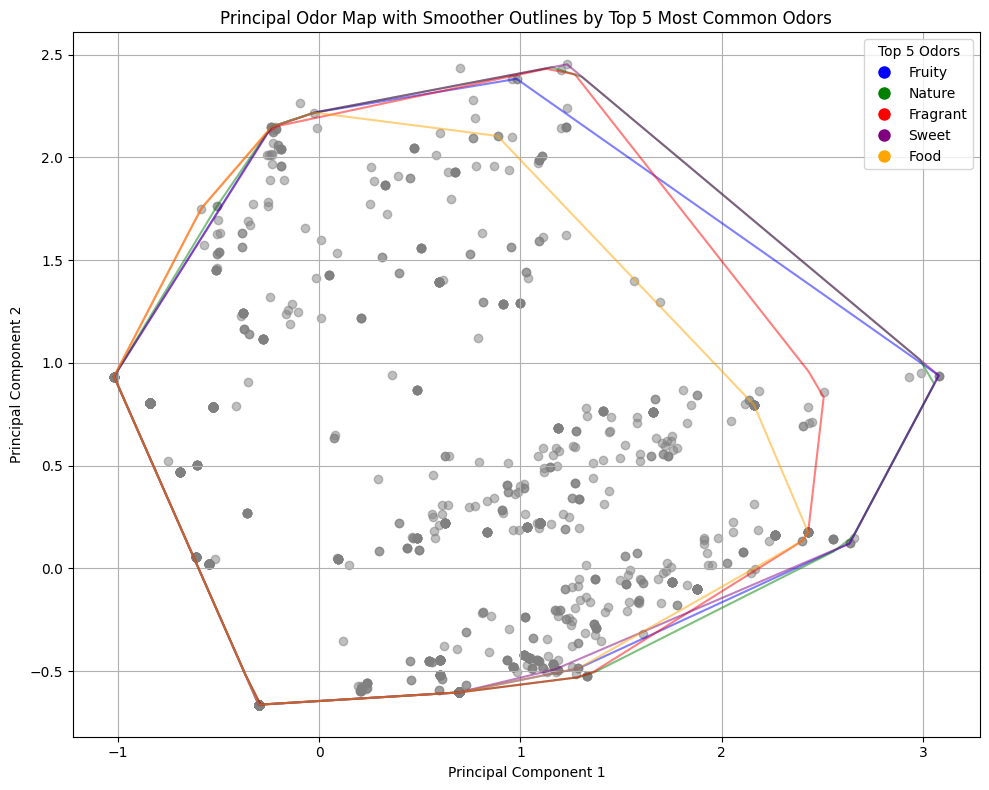

In [4]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem import AllChem
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

# Load CSV into DataFrame
df = pd.read_csv(r'C:\Users\igorh\Documents\SOFIA_MQ\data\curated_PrimaryOdor.csv')

# Function to extract scaffolds using RDKit (it extracts murcko-scaffolds)
def extract_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    return Chem.MolToSmiles(scaffold)

# Apply scaffold extraction to each SMILES in the dataset
df['scaffold'] = df['standardized_smiles'].apply(extract_scaffold)

# Create a new DataFrame for scaffolds and labels
scaffold_df = pd.DataFrame()

# Copy scaffolds to new DataFrame
scaffold_df['scaffold'] = df['scaffold']

# Maintain labels per scaffold in different columns (e.g., odor_1, odor_2, ...)
for i in range(1, 6):  # Assuming there are up to 5 odor columns
    col_name = f'odor_{i+1}'
    scaffold_df[col_name] = df[col_name]

# Create 'combined_odors' column
odor_columns = [col for col in scaffold_df.columns if col.startswith('odor_')]
scaffold_df['combined_odors'] = scaffold_df[odor_columns].apply(lambda row: ' '.join(row.dropna().astype(str)), axis=1)

# Function to generate Morgan fingerprints from SMILES
def smiles_to_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)  # Morgan fingerprint, radius=2, 1024 bits
    return np.array(fp)

# Apply smiles_to_fp function to each SMILES in the dataset
scaffold_df['fp'] = scaffold_df['scaffold'].apply(smiles_to_fp)

# Convert fingerprints to numpy array
X = np.array(scaffold_df['fp'].tolist())

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Determine top 5 most common odors
top_n = 5
odor_counts = scaffold_df[odor_columns].apply(pd.Series.value_counts).sum(axis=1)
top_odors = odor_counts.nlargest(top_n).index.tolist()

# Group data points by top 5 odors using K-means clustering as an example
odor_groups = {}
for odor in top_odors:
    label_indices = scaffold_df['combined_odors'].str.contains(odor)
    X_label = X_pca[label_indices]
    odor_groups[odor] = X_label

# Define colors for plotting outlines
colors = ['blue', 'green', 'red', 'purple', 'orange']

# Plot PCA results with gray points and smoother outlines for each top odor
plt.figure(figsize=(10, 8))

# Plot gray points
plt.scatter(X_pca[:, 0], X_pca[:, 1], color='gray', alpha=0.5, label='Other Odors')

# Plot smoother outlines for each top odor
for i, (odor, X_label) in enumerate(odor_groups.items()):
    # Calculate convex hull for the group
    hull = ConvexHull(X_label)

    # Extract points from convex hull
    points = X_label[hull.vertices]

    # Duplicate the last point to close the outline
    points = np.vstack([points, points[0]])

    # Interpolate between points for smoother outline
    t = np.arange(points.shape[0])
    interp = np.linspace(0, t.max(), 100)
    x_vals = np.interp(interp, t, points[:, 0])
    y_vals = np.interp(interp, t, points[:, 1])

    # Plot the interpolated outline
    plt.plot(x_vals, y_vals, color=colors[i], alpha=0.5, label=odor)

# Create legend for top 5 odors
legend_handles = []
for i, odor in enumerate(top_odors):
    legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=colors[i], markersize=10, label=odor))

# Add legend
plt.legend(handles=legend_handles, title='Top 5 Odors', loc='upper right')

plt.title('Principal Odor Map with Smoother Outlines by Top 5 Most Common Odors')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
from rdkit.Chem import BRICS
df = pd.read_csv(r'C:\Users\igorh\Documents\SOFIA_MQ\data\curated_PrimaryOdor.csv')

def brics_fragments(smiles):
    mol = Chem.MolFromSmiles(smiles)
    frags = BRICS.BRICSDecompose(mol, returnMols=True)
    frags_smiles = [Chem.MolToSmiles(frag) for frag in frags]
    return '.'.join(frags_smiles)

brics_fragments(df['standardized_smiles'][1])

'[7*]C(C)C.[7*]CCCC(C)(O)C#C'

In [8]:
df['standardized_smiles'][1]

'C#CC(C)(O)CCC=C(C)C'